生成数据

In [30]:
import pandas as pd
import math
import random
total_len = 1000
test_df = pd.DataFrame({"val": list(range(total_len))})
test_df["val"] = test_df["val"] / 100
test_df["val"] = test_df["val"].apply(lambda x: math.sin(x) * 100 + (random.randint(-10, 10)))

对数据进行切割

In [31]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
day_len = 15
x = np.array(test_df['val'][0:day_len])
y = np.array(test_df['val'][day_len])
for i in range(1, total_len - day_len):
    start_index = i
    end_index = i + day_len
    x = np.vstack((x, test_df['val'][start_index:end_index]))
    y = np.vstack((y, test_df['val'][end_index]))
train_x, test_x = train_test_split(x, shuffle=False)
train_y, test_y = train_test_split(y, shuffle=False)

In [32]:
import torch
# 初始化一个随机数，为什么呢？
# myseed = 42069  # set a random seed for reproducibility
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(myseed)
# torch.manual_seed(myseed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(myseed)
# 把设备信息获取一下
# device = "cuda" if torch.cuda.is_available() else "cpu"

train_x = torch.from_numpy(train_x).to(torch.float32)
train_y = torch.from_numpy(train_y).to(torch.float32)
test_x = torch.from_numpy(test_x).to(torch.float32)
test_y = torch.from_numpy(test_y).to(torch.float32)
print(train_x[0])

tensor([-1.0000e+00, -6.0000e+00, -3.0001e+00, -3.0004e+00, -1.0666e-03,
        -3.0021e+00, -2.0036e+00,  9.9943e+00,  1.5991e+01,  5.9879e+00,
         1.8983e+01,  4.9778e+00,  1.1971e+01,  1.1963e+01,  2.0954e+01])


创建模型

In [33]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
MODE_TRAIN=1
MODE_PREDICT=2
class MyDataset(Dataset):

    def __init__(self, mode, data, target):
        """
        @param
            mode: TRAIN/PREDICT
            data: input数据
            target: 结果数据
        """
        self.mode = mode
        self.data = data
        self.target = target
        self.dim = data.shape[1]
        
    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in (MODE_TRAIN, ):
            # For training
            return self.data[index], self.target[index]
        else:
            # For predict (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)
    
dl = DataLoader(MyDataset(MODE_TRAIN, train_x, train_y), batch_size=1, shuffle=True)


定义一个神经网络类

In [41]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 5),
            nn.Linear(5, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')
        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
    def forward(self, x):
        """ x = batchsize * dim """
        return self.net(x)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)
    
    @staticmethod
    def fit(dl, epochs):
        model = NeuralNetwork(dl.dataset.dim)
        model = model.to(model.device)
        optimizer = torch.optim.RMSprop(model.parameters())
        epoch = 0
        while epoch < epochs:
            total_loss = 0
            model.train()                           # set model to training mode
            for x, y in dl:                         # iterate through the dataloader
                optimizer.zero_grad()               # set gradient to zero
                x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
                pred = model(x)                     # forward pass (compute output)
                mse_loss = model.cal_loss(pred, y)  # compute loss
                mse_loss.backward()                 # compute gradient (backpropagation)
                optimizer.step()                    # update model with optimizer
                total_loss += mse_loss.detach().cpu().item() * len(x)
            total_loss = total_loss / len(dl.dataset)
            epoch += 1
            print("Saving model (epoch = {:d}/{:d}, loss = {:.4f})".format(epoch, epochs, total_loss))
        return model
    
    def predict(self, dl):
        self.eval()
        preds = []
        for x in dl:                                     # iterate through the dataloader
            x = x.to(self.device)                        # move data to device (cpu/cuda)
            with torch.no_grad():                        # disable gradient calculation
                pred = model(x)                          # forward pass (compute output)
                preds.append(pred.detach().cpu())        # collect prediction
        preds = torch.cat(preds, dim=0).numpy()          # concatenate all predictions and convert to a numpy array
        return preds
        

In [42]:
model = NeuralNetwork.fit(dl, epochs=100)

Saving model (epoch = 1/100, loss = 142.6378)
Saving model (epoch = 2/100, loss = 80.7508)
Saving model (epoch = 3/100, loss = 76.6267)
Saving model (epoch = 4/100, loss = 70.6608)
Saving model (epoch = 5/100, loss = 75.7353)
Saving model (epoch = 6/100, loss = 74.5938)
Saving model (epoch = 7/100, loss = 69.7673)
Saving model (epoch = 8/100, loss = 72.4402)
Saving model (epoch = 9/100, loss = 73.7320)
Saving model (epoch = 10/100, loss = 64.5175)
Saving model (epoch = 11/100, loss = 71.7878)
Saving model (epoch = 12/100, loss = 72.3360)
Saving model (epoch = 13/100, loss = 73.1998)
Saving model (epoch = 14/100, loss = 72.9877)
Saving model (epoch = 15/100, loss = 71.1659)
Saving model (epoch = 16/100, loss = 73.9616)
Saving model (epoch = 17/100, loss = 71.4546)
Saving model (epoch = 18/100, loss = 80.8947)
Saving model (epoch = 19/100, loss = 69.1544)
Saving model (epoch = 20/100, loss = 73.0271)
Saving model (epoch = 21/100, loss = 70.9457)
Saving model (epoch = 22/100, loss = 68.92

In [48]:
dl_test = DataLoader(MyDataset(MODE_PREDICT, test_x, None), batch_size=1, shuffle=False)
result = model.predict(dl_test)

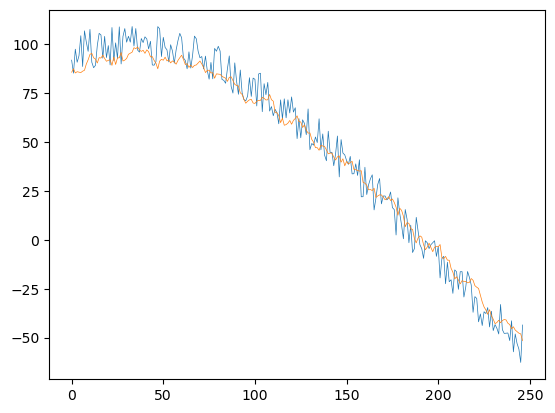

mse: 63.06692886352539


In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
x = list(range(len(test_y[:, 0])))
# plot
fig, ax = plt.subplots()
ax.plot(x, test_y[:, 0], linewidth=0.5, label="actual")
ax.plot(x, result[:, 0], linewidth=0.5, label="predict")
plt.show()
print(f'mse: {mean_squared_error(test_y[:, 0], result[:, 0])}')